# Random Forest With Recursive Elimination

Random Forest with Recursive Feature Elimination (RF-RFE) is a feature selection method that combines Random Forests for ranking feature importance with a systematic elimination process to identify the most predictive features. Random Forests assign importance scores to features based on their contribution to the model's accuracy. Recursive Feature Elimination (RFE) iteratively removes the least important features, retraining the model at each step to evaluate performance. By combining these, RF-RFE selects an optimal subset of features that maximizes model performance, often validated through cross-validation (e.g., RFECV). The code was adapted from https://github.com/NedraMekni/COVID-19 

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math
import hashlib
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm,linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel,RFE,RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler,KBinsDiscretizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR,LinearSVR
from sklearn import model_selection
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from numpy import transpose
from collections.abc import Iterable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import os
import glob


In [2]:
# Define paths
input_dir = "../../3_train_test_split/"
reduced_features_dir = "./"
plots_dir = "plots/"

problem_types = ["regression", "classification"]
seed = 42

# Create directories if they don't exist
os.makedirs(reduced_features_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [3]:
# Function to add a dummy variable for regression
def add_dummy_variable(df, y, target_column):
    is_imputed = (abs(y - (-np.log(10000 * 1e-9))) < 1e-6).astype(int)
    df["is_imputed"] = is_imputed.loc[df.index]
    return df

Processing regression data...
Optimal number of features for regression: 168
Selected features (168): ['DoubleCubicLatticePackingDensity', 'GETAWAY_0', 'GETAWAY_5', 'GETAWAY_7', 'GETAWAY_14', 'GETAWAY_22', 'GETAWAY_34', 'GETAWAY_39', 'GETAWAY_40', 'GETAWAY_52', 'GETAWAY_73', 'GETAWAY_81', 'GETAWAY_84', 'GETAWAY_94', 'GETAWAY_117', 'GETAWAY_120', 'GETAWAY_126', 'GETAWAY_131', 'GETAWAY_141', 'GETAWAY_142', 'GETAWAY_164', 'GETAWAY_167', 'GETAWAY_172', 'GETAWAY_174', 'GETAWAY_175', 'GETAWAY_176', 'GETAWAY_203', 'GETAWAY_220', 'GETAWAY_237', 'GETAWAY_239', 'GETAWAY_240', 'GETAWAY_245', 'GETAWAY_250', 'GETAWAY_253', 'GETAWAY_255', 'GETAWAY_258', 'GETAWAY_268', 'GETAWAY_269', 'GETAWAY_270', 'WHIM_8', 'WHIM_9', 'WHIM_13', 'WHIM_19', 'WHIM_26', 'WHIM_47', 'WHIM_83', 'MORSE_1', 'MORSE_2', 'MORSE_8', 'MORSE_9', 'MORSE_14', 'MORSE_24', 'MORSE_25', 'MORSE_30', 'MORSE_31', 'MORSE_33', 'MORSE_37', 'MORSE_41', 'MORSE_44', 'MORSE_49', 'MORSE_51', 'MORSE_58', 'MORSE_59', 'MORSE_61', 'MORSE_62', 'MORSE_8

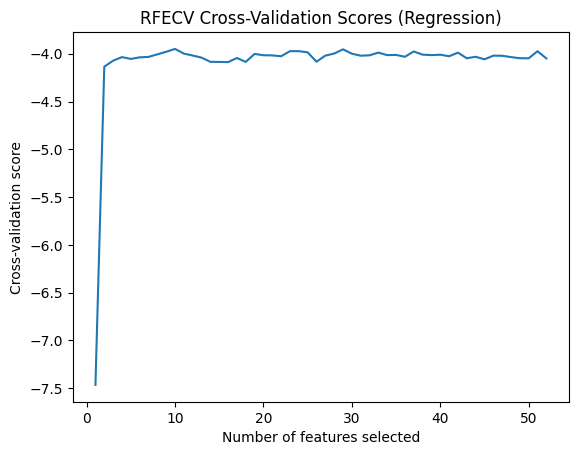

The peak cross-validation score for regression is: -3.9491492962652606
Processing classification data...
Optimal number of features for classification: 608
Selected features (608): ['PMI2', 'PMI3', 'Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PBF', 'RadiusOfGyration', 'SpherocityIndex', 'LabuteASA', 'DoubleCubicLatticeVolume', 'DoubleCubicLatticeSurfaceArea', 'DoubleCubicLatticeVDWVolume', 'DoubleCubicLatticePackingDensity', 'GETAWAY_0', 'GETAWAY_1', 'GETAWAY_3', 'GETAWAY_5', 'GETAWAY_6', 'GETAWAY_7', 'GETAWAY_8', 'GETAWAY_9', 'GETAWAY_11', 'GETAWAY_12', 'GETAWAY_14', 'GETAWAY_15', 'GETAWAY_16', 'GETAWAY_17', 'GETAWAY_18', 'GETAWAY_20', 'GETAWAY_21', 'GETAWAY_22', 'GETAWAY_24', 'GETAWAY_25', 'GETAWAY_26', 'GETAWAY_27', 'GETAWAY_28', 'GETAWAY_29', 'GETAWAY_30', 'GETAWAY_32', 'GETAWAY_33', 'GETAWAY_37', 'GETAWAY_38', 'GETAWAY_39', 'GETAWAY_40', 'GETAWAY_41', 'GETAWAY_43', 'GETAWAY_45', 'GETAWAY_47', 'GETAWAY_48', 'GETAWAY_49', 'GETAWAY_51', 'GETAWAY_52', 'GETAWA

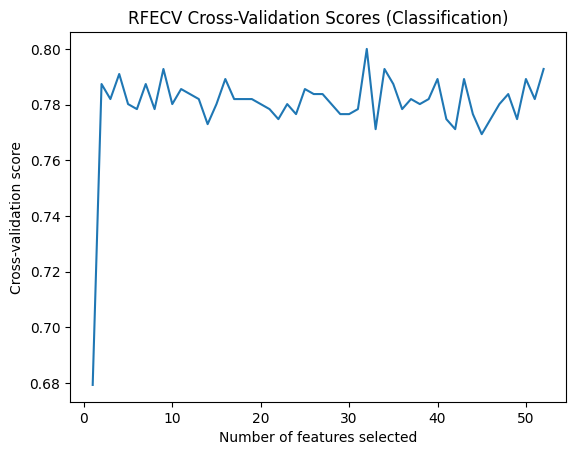

The peak cross-validation score for classification is: 0.8


In [4]:
for problem_type in problem_types:
    print(f"Processing {problem_type} data...")

    # 1. Read Data
    if problem_type == "regression":
        X = pd.read_csv(os.path.join(input_dir, "train_reg.csv")).set_index("Molecule ChEMBL ID")
        y = pd.read_csv(os.path.join(input_dir, "descriptors_all.csv")).set_index("Molecule ChEMBL ID")["-logIC50"]
        model = RandomForestRegressor(n_estimators=50, random_state=seed)
        cv = KFold(5)
        scoring = "neg_mean_squared_error"
    elif problem_type == "classification":
        X = pd.read_csv(os.path.join(input_dir, "train_class.csv")).set_index("Molecule ChEMBL ID")
        y = pd.read_csv(os.path.join(input_dir, "descriptors_all.csv")).set_index("Molecule ChEMBL ID")["Potency"]
        model = RandomForestClassifier(n_estimators=50, random_state=seed)
        cv = StratifiedKFold(5)
        scoring = "accuracy"

    y_train = y.loc[X.index]

    # 2. Apply RFECV
    rfecv = RFECV(
        estimator=model,
        step=20,  # Adjust step size to speed up or refine the process
        cv=cv,
        scoring=scoring,
        min_features_to_select=1
    )
    rfecv.fit(X, y_train)

    # Optimal number of features
    print(f"Optimal number of features for {problem_type}: {rfecv.n_features_}")

    # Reduced feature set
    selected_features = X.columns[rfecv.support_]
    print(f"Selected features ({len(selected_features)}): {list(selected_features)}")

    # 3. Save Reduced Features
    for file_path in glob.glob(os.path.join(input_dir, f"*_{problem_type[:3]}*")):
        # Extract file type (train, test, val)
        file_type = os.path.basename(file_path)

        # Read and reduce data
        df = pd.read_csv(file_path).set_index("Molecule ChEMBL ID")
        reduced_df = df[selected_features].copy()

        # Add dummy variable for regression
        if problem_type == "regression":
            reduced_df = add_dummy_variable(reduced_df, y, "-logIC50")

        # Save reduced features
        reduced_df.to_csv(os.path.join(reduced_features_dir, file_type))

        print(f"Saved reduced {file_type} data for {problem_type} to {reduced_features_dir}")

    # 4. Plot Cross-Validation Scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross-validation score")
    plt.plot(
        range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
        rfecv.cv_results_['mean_test_score']
    )
    plt.title(f"RFECV Cross-Validation Scores ({problem_type.capitalize()})")
    plt.savefig(os.path.join(plots_dir, f"{problem_type}_RFECV_CV_Scores.png"), dpi=300)
    plt.show()

    # Peak score
    peak_score = max(rfecv.cv_results_["mean_test_score"])
    print(f"The peak cross-validation score for {problem_type} is: {peak_score}")